## Using machine learning to map cell images to molecular state

In [1]:
#lets grab a couple packages and get started
import numpy as np
import matplotlib.pyplot as plt

First lets load up the data, which are single-cell images from live-cell phase-contrast microscopy of cultured MCF10A cells with EGF growth factor (imaged every 15 minutes over 48 hours, courtesy of Heiser Lab). Cells were first identified and identically sized 60 micron (40 pixel) square images extracted.

In [2]:
x_cells = np.load('EGF1_fov1_cellimages.npy') #single-cell images
print(x_cells.shape) #data is (samples , features) so each 40x40 image is flattened into a 1D vector
ncells = x_cells.shape[0]

(42936, 1600)


It is always a good idea to take a look at the data and try to make sense of it...

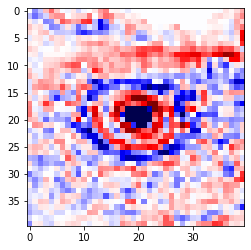

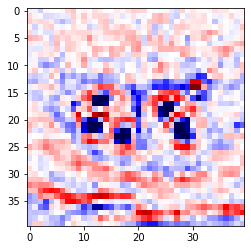

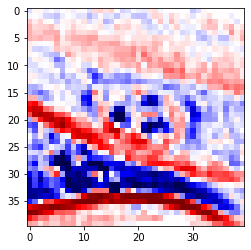

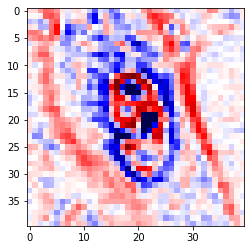

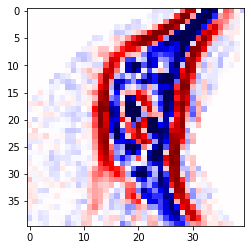

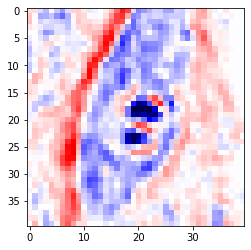

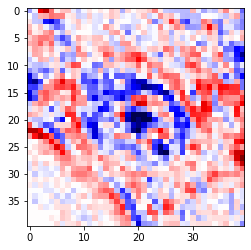

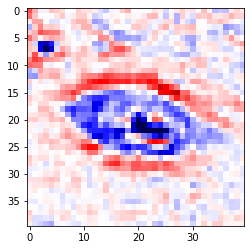

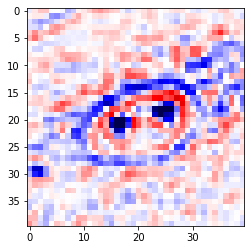

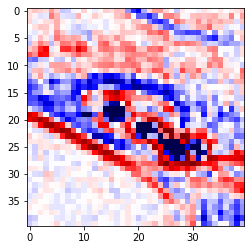

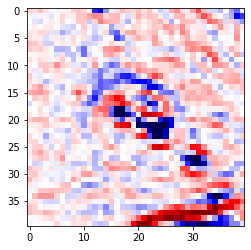

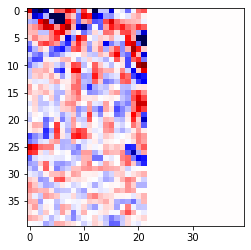

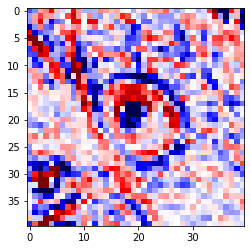

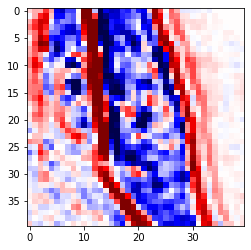

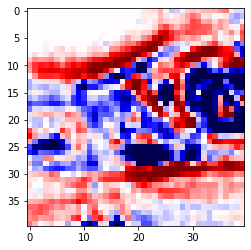

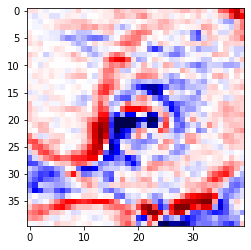

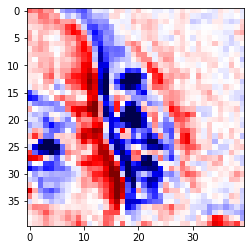

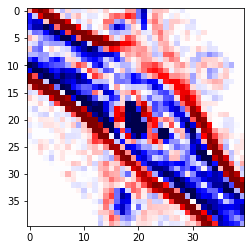

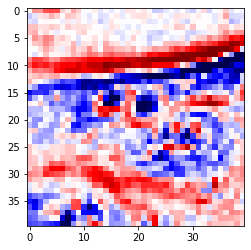

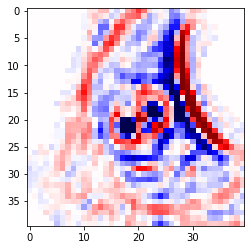

In [3]:
for ic in np.random.randint(0,ncells,20):
    plt.imshow(x_cells[ic,:].reshape(40,40),cmap=plt.cm.seismic,clim=[-4,4])
    plt.pause(.1)

This phase-contrast imaging was performed in conjunction with a cell-cycle reporter which translocates between the nucleus and cytoplasm and can be used as a molecular readout of cell-cycle. A biologically meaningful goal is to map between the cell morphology information in the phase-contrast cell images, and the cell-cycle information. Lets look and see if we can see a connection between the cell-cycle reporter levels and cell morphology.

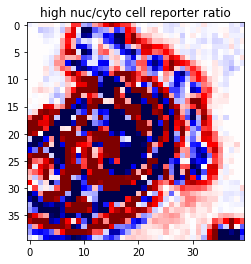

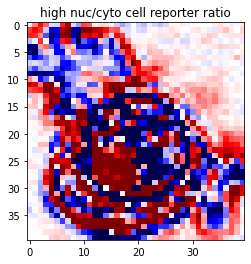

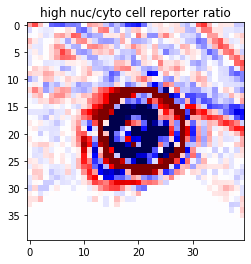

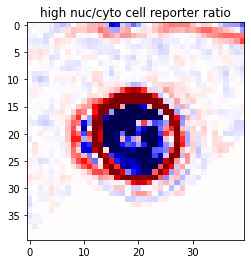

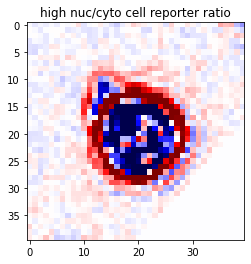

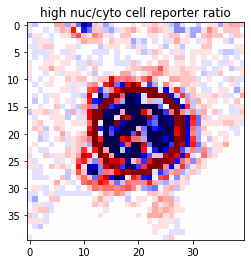

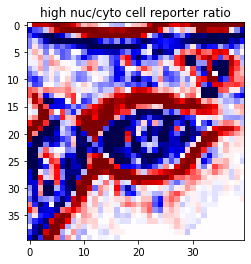

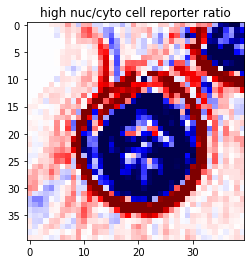

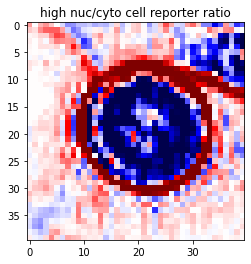

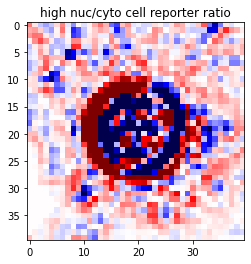

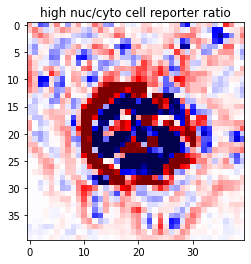

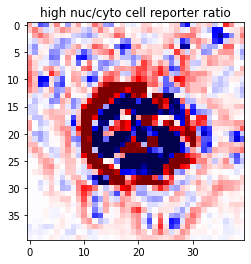

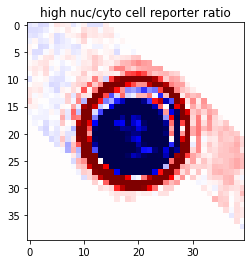

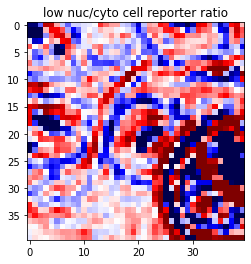

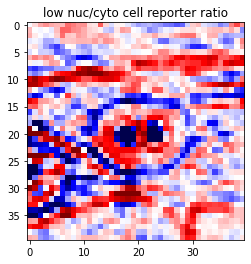

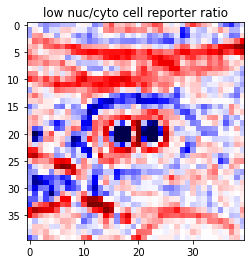

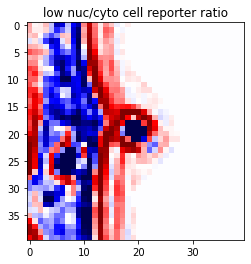

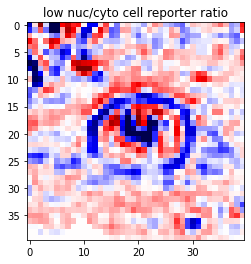

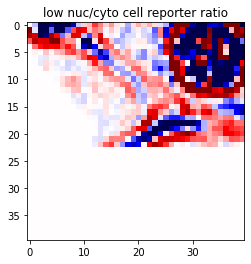

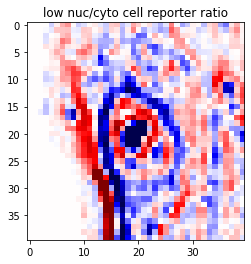

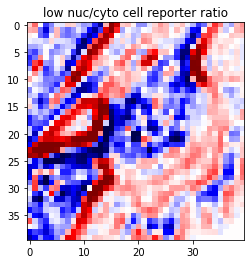

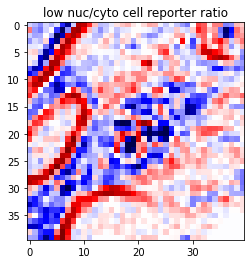

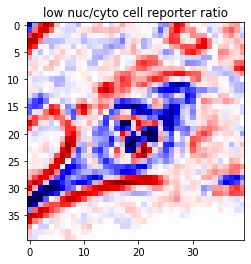

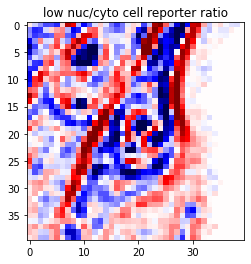

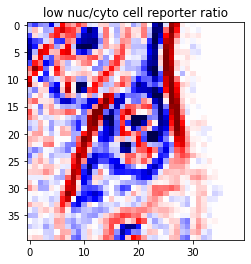

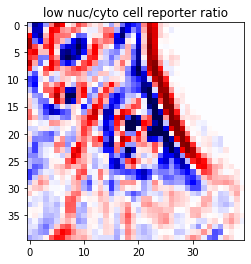

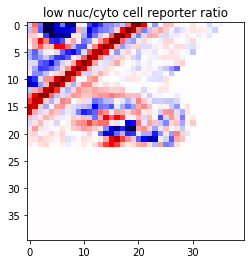

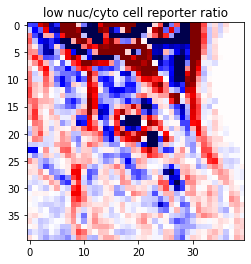

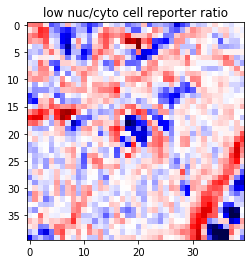

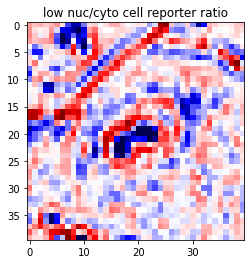

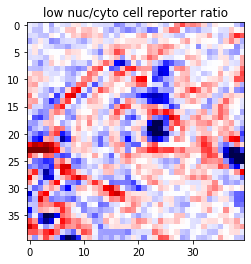

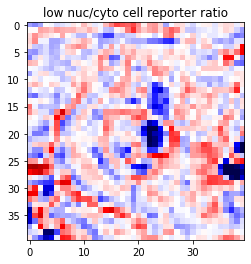

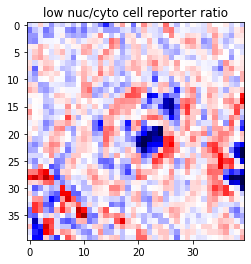

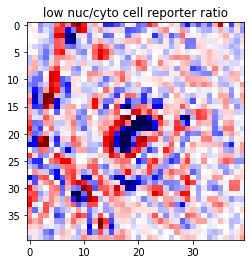

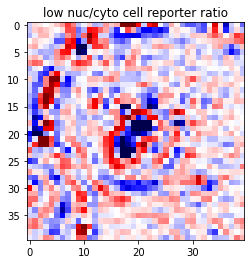

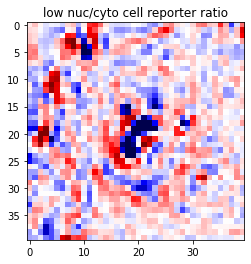

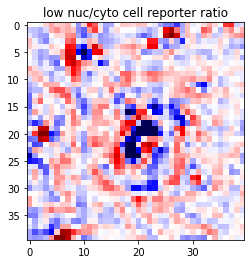

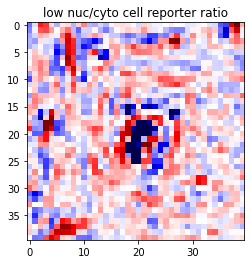

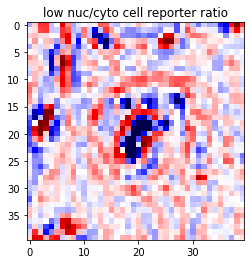

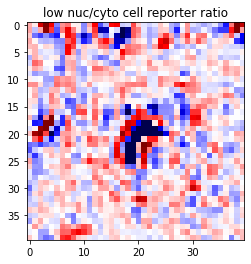

In [9]:
cc_ratio = np.load('EGF1_fov1_cc_ratio.npy') #ratio of nuclear to cytoplasmic cell-cycle reporter intensity
indhigh = np.where(cc_ratio > 20.0)[0] #indices where cc_ratio is very high indicative of mitosis
indlow=np.where(cc_ratio < .5)[0] #indices where cc_ratio is low indicative of G1 phase

npix=int(np.sqrt(x_cells.shape[1])) #number of linear pixels in the square image
for ic in indhigh:
    plt.clf()
    plt.title('high nuc/cyto cell reporter ratio')
    plt.imshow(x_cells[ic,:].reshape(npix,npix),cmap=plt.cm.seismic,clim=[-4,4])
    plt.pause(.1)

In [14]:
indsample = np.random.randint(0,ncells,2000) #randomly subsample the data so we don't overwork the local computers

Each of the 1600 pixels in the 40x40 image is a dimension of variation over the 42,936 single-cell images. That is a lot of dimensions! Our eye, which is a highly-trained neural network, can make some sense of this high-dimensional space. Perhaps your eye is able to pick out cell organelles such as nucleoli, lamellopodia, and membranes. From the unlabeled phase-contrast imaging, it can be hard to make sense of this data. Dimensionality reduction is one way to try to systematically map the variation present in high-dimensional data. Most dimensionality reduction methods fall under the category of unsupervised learning, where the goal is to try to explore the data.

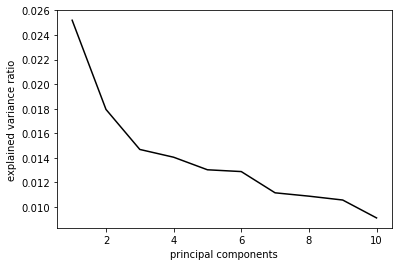

In [4]:
from sklearn.decomposition import PCA #we will use the sklearn package (intended for ease of use over performance/scalability)
pca = PCA(n_components=10) #n_components specifies the number of principal components to extract from the covariance matrix
pca.fit(x_cells) #builds the covariance matrix and "fits" the principal components
x_pca = pca.transform(x_cells) #transforms the data into the pca representation
plt.plot(np.arange(pca.n_components)+1,pca.explained_variance_ratio_,'k-') #lets look at how much of the variance is explained by each PC
plt.xlabel('principal components')
plt.ylabel('explained variance ratio')
plt.pause(.1)

 Lets check to see if there is a systematic variation of the first couple of PCs with the cc-ratio. 

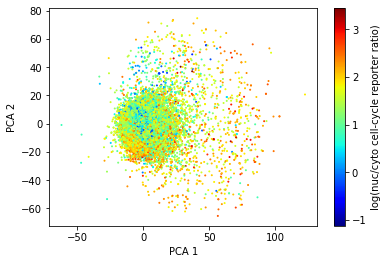

In [10]:
plt.clf()
plt.scatter(x_pca[:,0],x_pca[:,1],s=1,c=np.log(cc_ratio),cmap=plt.cm.jet)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
cbar=plt.colorbar()
cbar.set_label('log(nuc/cyto cell-cycle reporter ratio)') #log scales the color so we can visualize large and small values together
plt.pause(.1)

There doesn't seem to be a very systematic pattern in the PCA1/PCA2 space. But there were a lot of PCs needed to explain the variance in the data, so lets try a fancier non-linear dimensionality reduction which tries to learn a lower-dimensional manifold on which the data lies embedded in the higher-dimensional space. For ease of computation, we are also going to work with a random subsample of the data for the following examples. WARNING-- sampling and the amount of data drastically affects data-driven computations!

In [14]:
indsample = np.random.randint(0,ncells,2000) #randomly subsample the data so we don't overwork the local computers

Manifold learning is kind of like finding a representation that is what one might see as an ant "walking" along the the high-dimensional data from point to point-- so it needs a metric which provides a measure of how close or far data points are from eachother.
![manifold embedding](img/manifold_embedding.png)

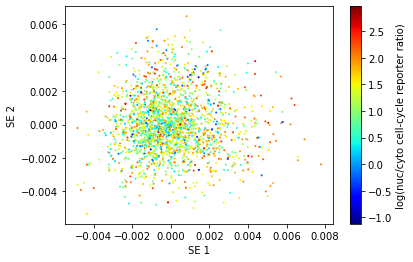

In [19]:
from sklearn.manifold import SpectralEmbedding
se = SpectralEmbedding(n_components=2)
x_se = se.fit_transform(x_cells[indsample,:]) #fit_transform fits the model and returns the coordinates in one command
plt.scatter(x_se[:,0],x_se[:,1],s=1,c=np.log(cc_ratio[indsample]),cmap=plt.cm.jet)
plt.xlabel('SE 1'); plt.ylabel('SE 2')
cbar=plt.colorbar()
cbar.set_label('log(nuc/cyto cell-cycle reporter ratio)')
plt.pause(.1)

Unsupervised learning is challenging in that the variability that dominates a particular representation/measurement of a cell (here phase-contrast images) is not always the variation one is interested in (here cell-cycle). We don't see any real connection between the cc-ratio values and the learned representation of the images. In situations where data is accompanied by known labels, supervised machine learning can learn a connection between labels (cell-cycle reporter) and data (phase-contrast images). This can answer the question of whether the data is sufficient to predict the label of interest. We will try 2 approaches. Linear regression learns a linear model from the data to the label (cc-ratio), and a neural network is a universal function whose parameters can be learned by minimizing a global loss funciton via a type of gradient descent.

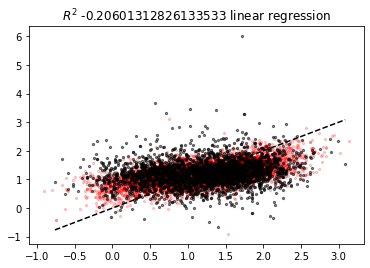

In [33]:
indsample = np.random.randint(0,ncells,10000) #randomly subsample the data so we don't overwork the local computers
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
regress_linear = LinearRegression()
X = x_cells[indsample,:] #cell represenation
y = np.log(cc_ratio[indsample]) #(label to learn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #splits the data into training and test sets
regress_linear.fit(X_train, y_train)
y_test_predicted = regress_linear.predict(X_test)
y_train_predicted = regress_linear.predict(X_train)
plt.clf()
plt.scatter(y_train,y_train_predicted,s=20,color='red',marker='.',alpha=0.2,label='training set')
plt.scatter(y_test,y_test_predicted,s=20,color='black',marker='.',alpha=0.5,label='test set')
plt.plot(np.array([np.min(y_test),np.max(y_test)]),np.array([np.min(y_test),np.max(y_test)]),'k--') #a perfect model would lie exactly on the diagonal
score_linear = regress_linear.score(X_test,y_test)
plt.title(r'$R^2$ '+str(score_linear)+' linear regression')
plt.pause(.1)

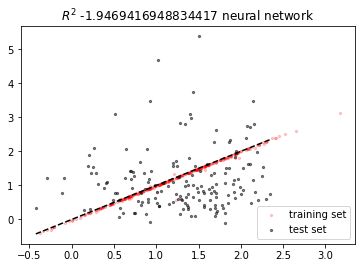

In [38]:
indsample = np.random.randint(0,ncells,500) #randomly subsample the data so we don't overwork the local computers
from sklearn.neural_network import MLPRegressor
regress_nn = MLPRegressor(hidden_layer_sizes=(256,64,16)) #these are the layers of the neural network and require lots of trial and error to optimize!
X = x_cells[indsample] #cell represenation
y = np.log(cc_ratio[indsample]) #(label to learn)
#y = np.log(cc_ratio[wctm.traj[:,-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regress_nn.fit(X_train, y_train) #under the hood: minimizes squared loss via stochastic gradient descent and back-propagation into the neural network layer weights
y_test_predicted = regress_nn.predict(X_test)
y_train_predicted = regress_nn.predict(X_train)
plt.clf()
plt.scatter(y_train,y_train_predicted,s=20,color='red',marker='.',alpha=0.2,label='training set')
plt.scatter(y_test,y_test_predicted,s=20,color='black',marker='.',alpha=0.5,label='test set')
plt.plot(np.array([np.min(y_test),np.max(y_test)]),np.array([np.min(y_test),np.max(y_test)]),'k--')
score_nn=regress_nn.score(X_test,y_test)
plt.title(r'$R^2$ '+str(score_nn)+' neural network')
plt.legend(loc='lower right')
plt.pause(.1)

Simple linear regression doesn't seem to capture any relationship between the images and the cc-ratio. The neural network learns the training set labels perfectly, but totally fails on the withheld test data. This is called overfitting and is the bane of the incredibly adaptable neural network architecture. This null result actually suggests that the raw data we are working with may not describe the morphological features we are interested in a direct fashion. One solution to this problem is to featurize the data in a way which ensures the information we know a priori to be important is represented directly in the data. Lets load up an already calculated featurization of the images. This includes things like shape parameters, cell-cell contact parameterization, cell-intensity distribution features, and texture features (another talk for another day).

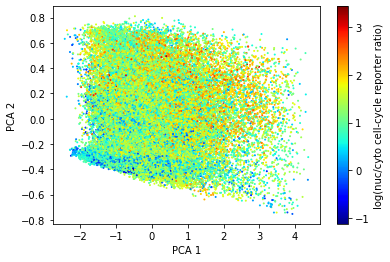

In [40]:
x_cells_features = np.load('EGF1_fov1_features.npy')
pca_features=PCA(n_components=10)
pca_features.fit(x_cells_features)
x_features_pca=pca_features.transform(x_cells_features)
plt.scatter(x_features_pca[:,0],x_features_pca[:,1],s=1,c=np.log(cc_ratio),cmap=plt.cm.jet)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
cbar=plt.colorbar()
cbar.set_label('log(nuc/cyto cell-cycle reporter ratio)')
plt.pause(.1)

There is a slight over-abundance of high cc-ratio levels in the upper right of the scatter-plot and more low cc-ratio levels in the lower left, suggesting that the cell features (sphericity, cell-cell contact) capture some of the necessary information determining cell-cycle state. Lets see if this has any affect on the supervised learning of the cc-ratio label.

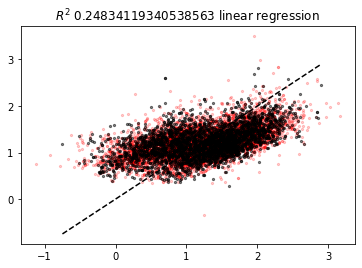

In [41]:
indsample = np.random.randint(0,ncells,10000) #randomly subsample the data so we don't overwork the local computers
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
regress_linear = LinearRegression()
X = x_cells_features[indsample,:] #cell represenation
y = np.log(cc_ratio[indsample]) #(label to learn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regress_linear.fit(X_train, y_train)
y_test_predicted = regress_linear.predict(X_test)
y_train_predicted = regress_linear.predict(X_train)
plt.clf()
plt.scatter(y_train,y_train_predicted,s=20,color='red',marker='.',alpha=0.2,label='training set')
plt.scatter(y_test,y_test_predicted,s=20,color='black',marker='.',alpha=0.5,label='test set')
plt.plot(np.array([np.min(y_test),np.max(y_test)]),np.array([np.min(y_test),np.max(y_test)]),'k--')
score_linear = regress_linear.score(X_test,y_test)
plt.title(r'$R^2$ '+str(score_linear)+' linear regression')
plt.pause(.1)

/home/copperma/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


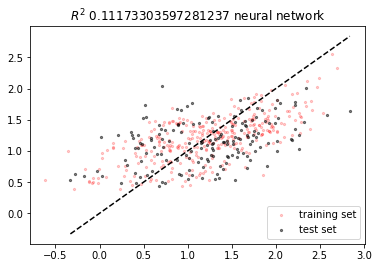

In [42]:
indsample = np.random.randint(0,ncells,500) #randomly subsample the data so we don't overwork the local computers
from sklearn.neural_network import MLPRegressor
regress_nn = MLPRegressor(hidden_layer_sizes=(256,64,16))
X = x_cells_features[indsample] #cell represenation
y = np.log(cc_ratio[indsample]) #(label to learn)
#y = np.log(cc_ratio[wctm.traj[:,-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regress_nn.fit(X_train, y_train)
y_test_predicted = regress_nn.predict(X_test)
y_train_predicted = regress_nn.predict(X_train)
plt.clf()
plt.scatter(y_train,y_train_predicted,s=20,color='red',marker='.',alpha=0.2,label='training set')
plt.scatter(y_test,y_test_predicted,s=20,color='black',marker='.',alpha=0.5,label='test set')
plt.plot(np.array([np.min(y_test),np.max(y_test)]),np.array([np.min(y_test),np.max(y_test)]),'k--')
score_nn=regress_nn.score(X_test,y_test)
plt.title(r'$R^2$ '+str(score_nn)+' neural network')
plt.legend(loc='lower right')
plt.pause(.1)

The improvement $R^2$ scores suggest there is now something which can be learned connecting the features of the phase-contrast images to the cell-cycle molecular state of the cell. Even better, the neural network performance on the training and test set are similar, showing that the neural net is learning from real signal. Just like we saw in the visual inspection of the images, the highest cc-ratio cells poised to undergo mitosis are the most predictable while low cc-ratio cells are not as recognizable. The low $R^2$ scores and weak correlation observed here shows these are pretty weak associations. It turns out that while the static features of cell morphology at one timepoint don't do a great job of predicting cell-cycle molecular state, feature trajectories of single-cell morphologies over time do (unpublished work).